In [1]:
import os
os.system("python3.11 src/scrape_links.py")

running async fetches...
parsing all links...
dumping 438/444 links to file...


0

In [6]:
import os
os.system("python3.11 src/scrape_pages.py")

running async fetches...
parsing all pages...
dumping all pages...


0

In [21]:
from src.clean_data import get_cleaned_data

df = get_cleaned_data()
df

cleaning data...
removing 16 rows with price >= 150000...
removing 25 rows with invalid district...
final length: 397


,url,last_update,price,district,bag_of_words,neubau,area,rooms,needs_fix,leased
0,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-06 06:55:00,149000.91,1050,perfekte starterwohnung in historischem altbau...,False,29.14,1.0,True,False
2,https://www.willhaben.at/iad/immobilien/d/eige...,2024-03-18 10:36:00,139000.00,1210,vermietete garçonniere in toplagezum verkauf g...,None,34.00,1.0,None,None
3,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-03 09:10:00,146000.00,1160,freundliche mini-wohnung mit niedrigen betrieb...,False,32.00,1.0,False,False
4,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-02 15:46:00,99000.00,1160,kleinwohnung in ruhelage mit direktem hofzugan...,False,30.00,2.0,True,False
5,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-03 19:35:00,125970.00,1170,* 1170 * hochparterre * unbefristet vermietet ...,False,37.05,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...
433,https://www.willhaben.at/iad/immobilien/d/eige...,2024-03-30 18:34:00,110000.00,1170,1 zimmer eigentumswohnung nahe hernals s-bahnz...,False,NaN,NaN,None,False
434,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-02 19:49:00,149000.00,1110,*preis-reduziert* schöne 2-zimmer-wohnung in g...,False,39.00,2.0,False,None
435,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-02 04:37:00,106500.00,1160,renovierungsbedürftige wohnung für nur 106.500...,False,27.34,1.0,True,None
436,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-02 04:38:00,139000.00,1150,nähe u3-station johnstraße - baubewilligter ba...,False,50.35,2.0,None,True


# pick best options

In [24]:
import webbrowser
import pandas as pd


def remove_deal_breakers(df_arg: pd.DataFrame) -> pd.DataFrame:
    dfcpy = df_arg.copy()

    prev_len = len(dfcpy)
    dfcpy = dfcpy[dfcpy['needs_fix'] != True]
    print(f"removed {prev_len - len(dfcpy)}: needs_fix == True")

    prev_len = len(dfcpy)
    dfcpy = dfcpy[dfcpy['leased'] != True]
    print(f"removed {prev_len - len(dfcpy)}: leased == True")

    bad_words = [
        "unbefristet",
        "befristet",
        # "renovierung",
        "renovier",
        # "sanierung",
        "sanier",
    ]
    prev_len = len(dfcpy)
    for word in bad_words:
        dfcpy = dfcpy[~dfcpy['bag_of_words'].str.contains(word, case=False)]
    print(f"removed {prev_len - len(dfcpy)}: bag_of_words contains bad words")

    assert type(dfcpy) == pd.DataFrame
    return dfcpy


def remove_non_premium(df_arg: pd.DataFrame) -> pd.DataFrame:
    dfcpy = df_arg.copy()

    prev_len = len(dfcpy)
    dfcpy = dfcpy[dfcpy["neubau"] != False]
    print(f"removed {prev_len - len(dfcpy)}: neubau == (False, None)")

    prev_len = len(dfcpy)
    good_words = [
        "südseitig",
    ]
    for word in good_words:
        dfcpy = dfcpy[dfcpy['bag_of_words'].str.contains(word, case=False)]
    print(f"removed {prev_len - len(dfcpy)}: bag_of_words does not contain good words")

    assert type(dfcpy) == pd.DataFrame
    return dfcpy


dfcpy = remove_deal_breakers(df)
# dfcpy = remove_non_premium(dfcpy)
print("final count:", len(dfcpy))

dfcpy = dfcpy.sort_values(by='price', ascending=True) # type: ignore

urls = dfcpy['url'].tolist()
counter = 0
for url in urls:
    counter += 1
    print(f"progress {counter/len(urls)*100:.2f}%", end="\r")
    webbrowser.open(url)


removed 99: needs_fix == True
removed 10: leased == True
removed 207: bag_of_words contains bad words
final count: 81


0:202: execution error: File some object wasn’t found. (-43)
69:77: execution error: Can’t get application "chrome". (-1728)
70:78: execution error: Can’t get application "firefox". (-1728)


/var/folders/bh/4ympj4l52bs8wxpg114kdh1m0000gn/T/ipykernel_69587/647368856.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_xticklabels(df["last_update"].dt.strftime('%Y-%m-%d'), rotation=90, fontsize=7)


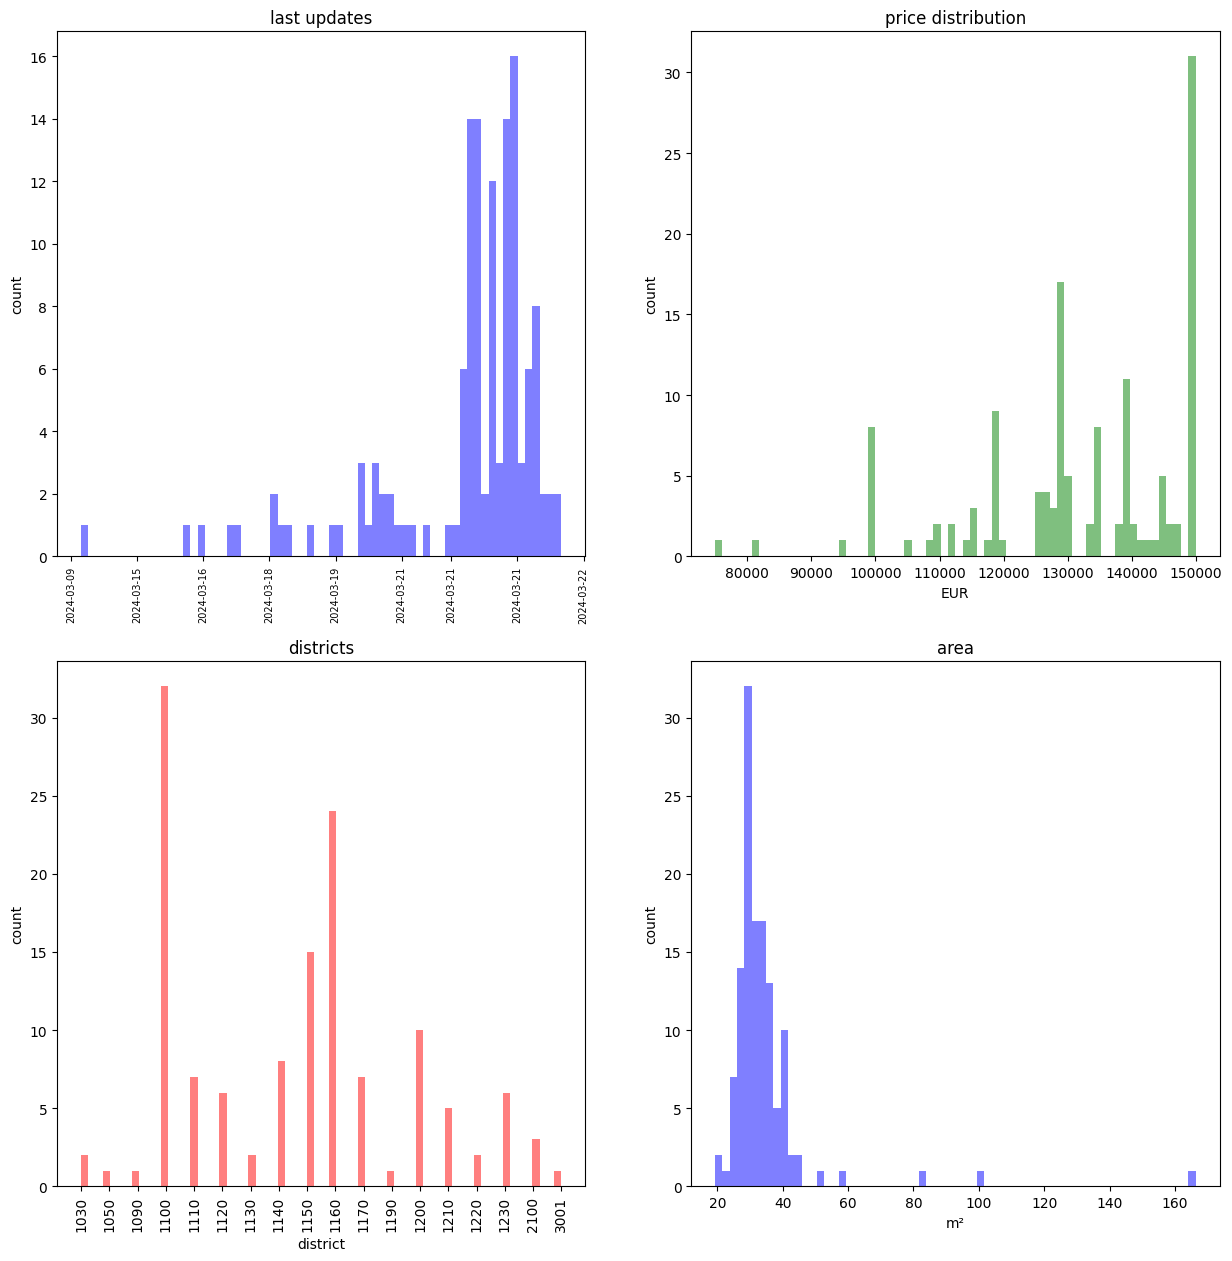

In [20]:
import matplotlib.pyplot as plt

df = dfcpy # comment out to use original df

fig, axs = plt.subplots(2, 2, figsize=(15, 15))


df = df.sort_values(by="last_update")
axs[0, 0].set_title("last updates")
axs[0, 0].hist(df["last_update"], bins=len(df) // 2, color="blue", alpha=0.5)
axs[0, 0].set_xticklabels(df["last_update"].dt.strftime('%Y-%m-%d'), rotation=90, fontsize=7)
axs[0, 0].set_ylabel("count")

axs[0, 1].set_title("price distribution")
axs[0, 1].hist(df["price"], bins=len(df) // 2, color="green", alpha=0.5)
axs[0, 1].set_xlabel("EUR")
axs[0, 1].set_ylabel("count")

df = df.sort_values(by="district")
axs[1, 0].set_title("districts")
axs[1, 0].hist(df.sort_values(by="district")["district"], bins=len(df) // 2, color="red", alpha=0.5)
axs[1, 0].set_xticks(range(len(df["district"].unique())))
axs[1, 0].set_xticklabels(df["district"].unique(), rotation=90)
axs[1, 0].set_xlabel("district")
axs[1, 0].set_ylabel("count")

axs[1, 1].set_title("area")
axs[1, 1].hist(df["area"], bins=len(df) // 2, color="blue", alpha=0.5)
axs[1, 1].set_xlabel("m²")
axs[1, 1].set_ylabel("count")

plt.show()